In [58]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd


In [59]:
random.seed(51)

In [60]:
# Filter the images before adding them to image folder
class FilteredImageFolder(dset.ImageFolder):
    def __init__(self, root, transform=None, image_list=None):
        super().__init__(root, transform)
        self.image_list = set(image_list)  # Convert to a set for fast lookup

        # Filter the images by their base name (without extension)
        self.samples = [sample for sample in self.samples if os.path.splitext(os.path.basename(sample[0]))[0] in self.image_list]
        self.targets = [s[1] for s in self.samples]
        
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


C:\Users\Shiyu Wu\AppData\Local\Temp\ipykernel_7936\834936565.py:9: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train-metadata.csv')


***


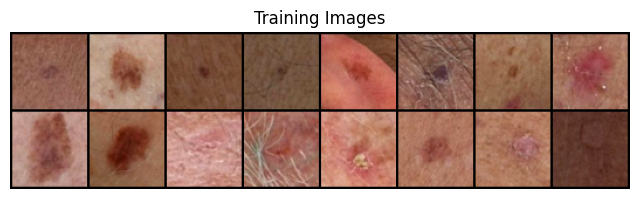

In [61]:

# Global constants
traindir = "./train-image"
image_size = 64
batch_size = 32
workers = 0
nz = 100

# Load the labels and find the label associated with malignant lesions
df = pd.read_csv('train-metadata.csv')
df = df[['isic_id','target']]
df = df[df['target'] == 1]
malignant_id = df['isic_id']

# Load the filtered images folder and dataloader
dataset = FilteredImageFolder(root=traindir, transform=transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]), image_list=malignant_id)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Show the images for test
real_batch = next(iter(dataloader))
print("***")
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )
        
    def forward(self, w):
        return self.model(w)

In [63]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )
    
    def forward(self, w):
        return self.model(w)

In [64]:
# Hyper parameters
epochs = 100
lr = 0.005
beta1 = 0.1

# Initialize the Generator and Discriminator and their optimizers
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas = (beta1, 0.99))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas = (beta1, 0.99))

# Initialize the loss function
criterion = nn.BCELoss()


In [65]:
# Training
img_list = []
G_losses = []
D_losses = []
iters = 0
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # Train with all-real batches
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with all-fake batches
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # Update the Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, epochs, i, len(dataloader),errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/100][0/13]	Loss_D: 1.5526	Loss_G: 42.9024	D(x): 0.4652	D(G(z)): 0.4529 / 0.0000
[1/100][0/13]	Loss_D: 5.1508	Loss_G: 12.3431	D(x): 0.7579	D(G(z)): 0.5732 / 0.0622
[2/100][0/13]	Loss_D: 1.0918	Loss_G: 14.4837	D(x): 0.8849	D(G(z)): 0.3317 / 0.0014
[3/100][0/13]	Loss_D: 1.8258	Loss_G: 3.0319	D(x): 0.6753	D(G(z)): 0.2767 / 0.3285
[4/100][0/13]	Loss_D: 2.2721	Loss_G: 5.7855	D(x): 0.5296	D(G(z)): 0.1516 / 0.2757
[5/100][0/13]	Loss_D: 15.9685	Loss_G: 4.4091	D(x): 0.9330	D(G(z)): 0.9311 / 0.1971
[6/100][0/13]	Loss_D: 14.2363	Loss_G: 3.2254	D(x): 0.6109	D(G(z)): 0.3621 / 0.2476
[7/100][0/13]	Loss_D: 4.2352	Loss_G: 6.5134	D(x): 0.8198	D(G(z)): 0.5869 / 0.0141
[8/100][0/13]	Loss_D: 3.1303	Loss_G: 2.1182	D(x): 0.7409	D(G(z)): 0.6646 / 0.2310
[9/100][0/13]	Loss_D: 2.0691	Loss_G: 2.7202	D(x): 0.7283	D(G(z)): 0.6424 / 0.3713
[10/100][0/13]	Loss_D: 7.2013	Loss_G: 1.7411	D(x): 0.7520	D(G(z)): 0.3333 / 0.2286
[11/100][0/13]	Loss_D: 1.9790	Loss_G: 4.4480	D(x): 0.9945	D(G(z)): 0.8003 / 0.2211
[12/100][

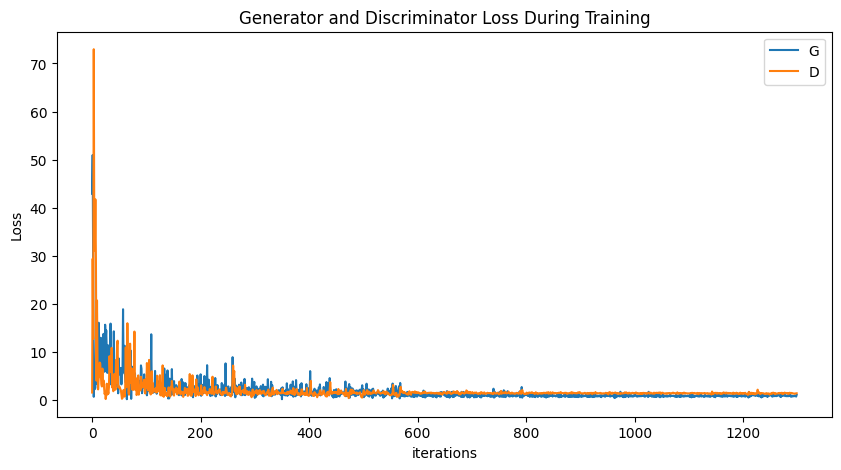

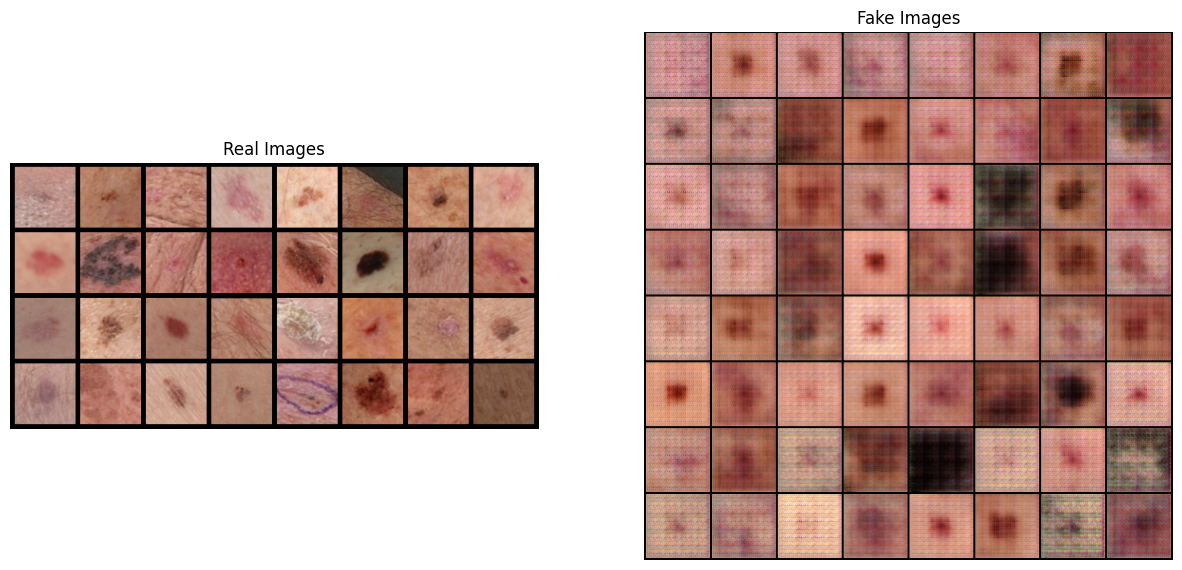

In [66]:
# Visualization
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()